In [139]:
import matplotlib.pyplot as plt
from matplotlib import style
import pybamm
from Durdel2023_single import get_test_parameter_values, get_final_parameter_values
pybamm.set_logging_level("DEBUG")


In [140]:

"Primary Active Material"
rho_si = 2.336 #from ref (supplementary material)
wt_si = .679 #% from ref
"Secondary Active Material"
rho_c6 = 2.255 # (C-NERGYTM KS6L)
wt_c6 = .199
"Inactive Material"
rho_cb = 2.00 #from ref
wt_cb = 0.02 # from ref
rho_lipaa = 1.2 #ref
wt_lipaa = 0.082 # ref
rho_cmc = 1.6 #ref
wt_cmc = 0.002 #ref

v_tot  = wt_si/rho_si + wt_c6/rho_c6 + wt_cb/rho_cb + wt_lipaa/rho_lipaa + wt_cmc/rho_cmc
v_si = wt_si/rho_si
v_c6 = wt_c6/rho_c6
v_im = wt_c6/rho_c6 + wt_lipaa/rho_lipaa + wt_cmc/rho_cmc

eps_si = 0.5 * v_si / v_tot #times 0.5 to account for porosity (eps_ely = 0.5)
eps_c6 = 0.5 * v_c6 / v_tot
eps_am = 0.5* (v_si + v_c6) / v_tot

cell_volume = 0.0124*0.0124*(92e-06 + 1.2e-05 + 2.6e-05 + 136e-06 +1.5e-05)

print("Volume fraction of Si: ", eps_si
      , "Volume fraction of C6: ", eps_c6, "Volume fraction of AM: ", eps_am, "cell volume: ", cell_volume)

Volume fraction of Si:  0.31697725057239584 Volume fraction of C6:  0.09623602768522001 Volume fraction of AM:  0.41321327825761583 cell volume:  4.3206559999999996e-08


In [141]:
model = pybamm.lithium_ion.DFN(
    {
     "open-circuit potential": ("Axen", "single"), #turning on voltage hysteresis for anode and cathode
     #"working electrode": "negative",
     "SEI": "none",
     "lithium plating": "none",
    }
)

2025-08-31 13:01:12.880 - [INFO] base_model._build_model(907): Start building Doyle-Fuller-Newman model
2025-08-31 13:01:12.881 - [DEBUG] base_model.build_fundamental(809): Getting fundamental variables for external circuit submodel (Doyle-Fuller-Newman model)
2025-08-31 13:01:12.882 - [DEBUG] base_model.build_fundamental(809): Getting fundamental variables for discharge and throughput variables submodel (Doyle-Fuller-Newman model)
2025-08-31 13:01:12.883 - [DEBUG] base_model.build_fundamental(809): Getting fundamental variables for porosity submodel (Doyle-Fuller-Newman model)
2025-08-31 13:01:12.884 - [DEBUG] base_model.build_fundamental(809): Getting fundamental variables for Negative interface utilisation submodel (Doyle-Fuller-Newman model)
2025-08-31 13:01:12.884 - [DEBUG] base_model.build_fundamental(809): Getting fundamental variables for Positive interface utilisation submodel (Doyle-Fuller-Newman model)
2025-08-31 13:01:12.885 - [DEBUG] base_model.build_fundamental(809): Gett

In [142]:


model.print_parameter_info()


┌───────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Parameter                                                 │ Type of parameter                                                                                                                                                                                           │
├───────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Separator Bruggeman coefficient (electrolyte)             │ Parameter                                                                                                                             

In [143]:
param = pybamm.ParameterValues(get_final_parameter_values())

# param.update(
#     {
#         "Primary: Negative electrode active material volume fraction": 0.09623602768522001, # primary
#         "Secondary: Negative electrode active material volume fraction": 0.31697725057239584,
#         "Negative electrode porosity": 0.5,
#     }
#     )

param.update(
    {
    "Minimum stoichiometry in negative electrode": 0.0387,
    "Maximum stoichiometry in negative electrode": 0.2960,
    "Minimum stoichiometry in positive electrode": 0.1396,
    "Maximum stoichiometry in positive electrode": 0.7954,
    }, check_already_exists=False)


# Axen parameters
param.update(
    {
        "Negative particle lithiation hysteresis decay rate": 100,
        "Negative particle delithiation hysteresis decay rate": 100,
        "Initial hysteresis state in negative electrode": 1,
    }, check_already_exists=False,
)


In [144]:
experiment = pybamm.Experiment(
    [
        (
            "Rest for 5 minutes",
            "Discharge at C/1 until 2.8 V",
            "Rest for 5 minutes",
            "Charge at C/10 until 4.15 V",
            "Rest for 5 minutes",
            "Discharge at C/10 until 2.8 V",
        ),
    ],
    period="10 seconds",

)


In [145]:
solver=pybamm.IDAKLUSolver(rtol=1e-4, atol=1e-4)
#solver=pybamm.CasadiSolver(rtol=1e-3, atol=1e-3, mode='safe', return_solution_if_failed_early=True)

sim = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment = experiment,
    solver=solver
)
solution = sim.solve()

#solution.plot()




2025-08-31 13:01:10.495 - [INFO] callbacks.on_experiment_start(162): Start running experiment
2025-08-31 13:01:10.496 - [INFO] parameter_values.process_model(475): Start setting parameters for Doyle-Fuller-Newman model
2025-08-31 13:01:10.497 - [VERBOSE] logger.func(7): Processing parameters for Variable(0x1d5b6e2c738b27a4, Discharge capacity [A.h], children=[], domains={}) (rhs)
2025-08-31 13:01:10.497 - [VERBOSE] logger.func(7): Processing parameters for Variable(0x50a4f9aea761037c, Throughput capacity [A.h], children=[], domains={}) (rhs)
2025-08-31 13:01:10.498 - [VERBOSE] logger.func(7): Processing parameters for Variable(0x6c0144a3cca6db64, Negative electrode hysteresis state, children=[], domains={'primary': ['negative electrode'], 'secondary': ['current collector']}) (rhs)
2025-08-31 13:01:10.502 - [VERBOSE] logger.func(7): Processing parameters for Variable(0x11c37218d371aa68, Negative particle concentration [mol.m-3], children=[], domains={'primary': ['negative particle'], 's

In [146]:

#debug stuff


xn = solution["X-averaged negative particle stoichiometry"].data
xp = solution["X-averaged positive particle stoichiometry"].data

debug_var = solution["Terminal voltage [V]"].data


print(xn.min(), xn.max(), xp.min(), xp.max())
print(debug_var.shape)
print(debug_var)

print(solution["Negative electrode stoichiometry"].data)
print(solution["Positive electrode stoichiometry"].data)

2025-08-31 13:01:15.783 - [DEBUG] solution._update_variable(424): Post-processing X-averaged negative particle stoichiometry
2025-08-31 13:01:15.796 - [DEBUG] processed_variable._observe_raw(175): Observing the variable raw data
2025-08-31 13:01:15.798 - [DEBUG] processed_variable._setup_inputs(123): Setting up C++ interpolation inputs
2025-08-31 13:01:15.848 - [DEBUG] solution._update_variable(424): Post-processing X-averaged positive particle stoichiometry
2025-08-31 13:01:15.857 - [DEBUG] processed_variable._observe_raw(175): Observing the variable raw data
2025-08-31 13:01:15.857 - [DEBUG] processed_variable._setup_inputs(123): Setting up C++ interpolation inputs
2025-08-31 13:01:15.891 - [DEBUG] solution._update_variable(424): Post-processing Terminal voltage [V]
2025-08-31 13:01:15.895 - [DEBUG] processed_variable._observe_raw(175): Observing the variable raw data
2025-08-31 13:01:15.896 - [DEBUG] processed_variable._setup_inputs(123): Setting up C++ interpolation inputs
2025-08-

0.03912165913834724 0.3024115339890593 0.15280355965083064 0.7940710553382754
(12720,)
[3.35724751 3.35724749 3.35724749 ... 2.80085266 2.80035393 2.8       ]
[0.1732     0.1732     0.1732     ... 0.03981145 0.03976976 0.03974017]
[0.4675     0.4675     0.4675     ... 0.79295727 0.79305899 0.79313118]


In [147]:
model.variable_names()

model.variables.search("concentration")

Results for 'concentration': ['Negative particle concentration [mol.m-3]', 'X-averaged negative particle concentration [mol.m-3]', 'R-averaged negative particle concentration [mol.m-3]', 'Average negative particle concentration [mol.m-3]', 'Negative particle surface concentration [mol.m-3]', 'X-averaged negative particle surface concentration [mol.m-3]', 'Minimum negative particle concentration [mol.m-3]', 'Maximum negative particle concentration [mol.m-3]', 'Minimum negative particle Minimum negative particle surface concentration [mol.m-3]', 'Maximum negative particle surface concentration [mol.m-3]', 'Negative particle concentration', 'X-averaged negative particle concentration', 'R-averaged negative particle concentration', 'Average negative particle concentration', 'Negative particle surface concentration', 'X-averaged negative particle surface concentration', 'Minimum negative particle concentration', 'Maximum negative particle concentration', 'Minimum negative particle surface c

2025-08-31 13:01:16.051 - [DEBUG] solution._update_variable(424): Post-processing Time [h]


2025-08-31 13:01:16.054 - [DEBUG] processed_variable._observe_raw(175): Observing the variable raw data
2025-08-31 13:01:16.054 - [DEBUG] processed_variable._setup_inputs(123): Setting up C++ interpolation inputs
2025-08-31 13:01:16.057 - [DEBUG] solution._update_variable(424): Post-processing Battery open-circuit voltage [V]
2025-08-31 13:01:16.076 - [DEBUG] processed_variable._observe_raw(175): Observing the variable raw data
2025-08-31 13:01:16.076 - [DEBUG] processed_variable._setup_inputs(123): Setting up C++ interpolation inputs
2025-08-31 13:01:16.148 - [DEBUG] solution._update_variable(424): Post-processing Battery particle concentration overpotential [V]
2025-08-31 13:01:16.175 - [DEBUG] processed_variable._observe_raw(175): Observing the variable raw data
2025-08-31 13:01:16.176 - [DEBUG] processed_variable._setup_inputs(123): Setting up C++ interpolation inputs
2025-08-31 13:01:16.287 - [DEBUG] solution._update_variable(424): Post-processing X-averaged battery reaction overp

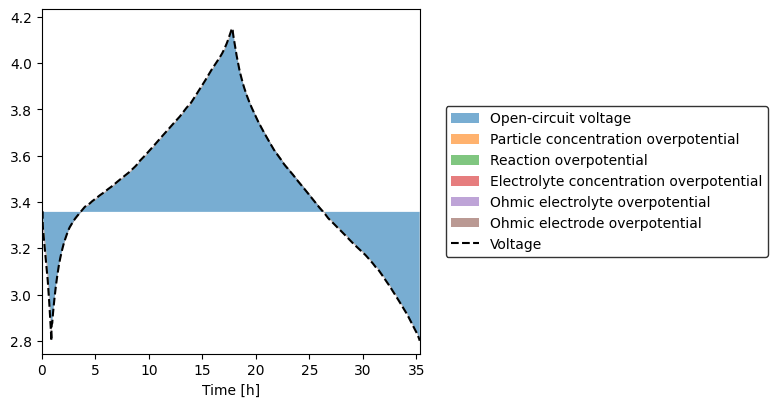

2025-08-31 13:01:16.620 - [DEBUG] solution._update_variable(424): Post-processing Negative particle surface concentration [mol.m-3]
2025-08-31 13:01:16.626 - [DEBUG] processed_variable._observe_raw(175): Observing the variable raw data
2025-08-31 13:01:16.626 - [DEBUG] processed_variable._setup_inputs(123): Setting up C++ interpolation inputs
2025-08-31 13:01:16.643 - [DEBUG] solution._update_variable(424): Post-processing Electrolyte concentration [mol.m-3]
2025-08-31 13:01:16.646 - [DEBUG] processed_variable._observe_raw(175): Observing the variable raw data
2025-08-31 13:01:16.647 - [DEBUG] processed_variable._setup_inputs(123): Setting up C++ interpolation inputs
2025-08-31 13:01:16.663 - [DEBUG] solution._update_variable(424): Post-processing Positive particle surface concentration [mol.m-3]
2025-08-31 13:01:16.669 - [DEBUG] processed_variable._observe_raw(175): Observing the variable raw data
2025-08-31 13:01:16.669 - [DEBUG] processed_variable._setup_inputs(123): Setting up C++ 

interactive(children=(FloatSlider(value=0.0, description='t', max=35.312486509648295, step=0.35312486509648294…

2025-08-31 13:01:17.380 - [DEBUG] solution._update_variable(424): Post-processing Time [s]
2025-08-31 13:01:17.381 - [DEBUG] processed_variable._observe_raw(175): Observing the variable raw data
2025-08-31 13:01:17.382 - [DEBUG] processed_variable._setup_inputs(123): Setting up C++ interpolation inputs
2025-08-31 13:01:17.391 - [DEBUG] solution._update_variable(424): Post-processing Discharge capacity [A.h]
2025-08-31 13:01:17.392 - [DEBUG] processed_variable._observe_raw(175): Observing the variable raw data
2025-08-31 13:01:17.392 - [DEBUG] processed_variable._setup_inputs(123): Setting up C++ interpolation inputs
2025-08-31 13:01:17.397 - [DEBUG] solution._update_variable(424): Post-processing Total lithium capacity [A.h]
2025-08-31 13:01:17.408 - [DEBUG] processed_variable._observe_raw(175): Observing the variable raw data
2025-08-31 13:01:17.408 - [DEBUG] processed_variable._setup_inputs(123): Setting up C++ interpolation inputs


Text(0, 0.5, 'Full Cell Potential in V)')

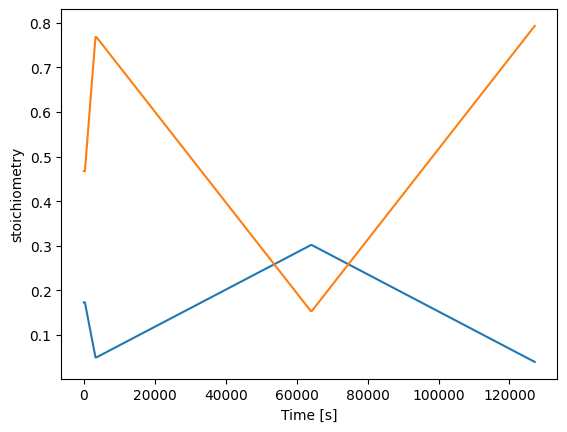

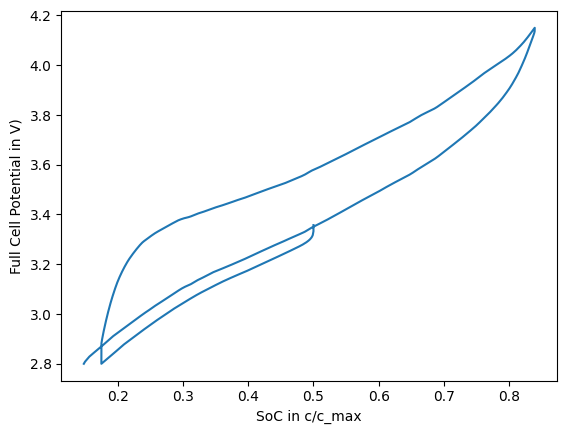

In [148]:
#debug plots

pybamm.plot_voltage_components(solution)


solution.plot()


sto_neg = solution["Negative electrode stoichiometry"].data
sto_pos = solution["Positive electrode stoichiometry"].data
time = solution["Time [s]"].data

plt.figure()
plt.plot(time, sto_neg)
plt.plot(time, sto_pos)
plt.xlabel("Time [s]")
plt.ylabel("stoichiometry")



OCP = solution["Voltage [V]"].data
SoC = 0.5 - (solution["Discharge capacity [A.h]"].data/solution["Total lithium capacity [A.h]"].data)
#0.5 minus because the initial condition is @0.5C


plt.figure()
plt.plot(SoC, OCP)
plt.xlabel("SoC in c/c_max")
plt.ylabel("Full Cell Potential in V)")





In [149]:
#output

# sim.plot(output_variables=["Voltage [V]", 
#                            "Current [A]",
#                            "Negative particle surface concentration [mol.m-3]",
#                            "Positive particle surface concentration [mol.m-3]",
#                            "Negative electrode potential [V]",
#                            "Positive electrode potential [V]",
#                            "X-averaged negative electrode open-circuit potential [V]",
#                            "X-averaged positive electrode open-circuit potential [V]",
#                             ])


In [ ]:
#Paper replication EXPERIMENTS



gitt_c1 = pybamm.Experiment(
    [
        (
        "Discharge at C/1 until 2.8 V",
        "Rest for 2 hours",
        ),
        #To initial the battery because initializing using concentrations breaks it
        (
        "Charge at C/1 for 3 minutes or until 4.15 V",
        "Rest for 2 hours or until 4.15 V",
        )*50,
        #round brackets define a cycle
        #each line is a step
        (
        "Discharge at C/1 for 3 minutes or until 2.8 V",
        "Rest for 2 hours or until 2.8 V",
        )*50
    ],
)

cc_c1 = pybamm.Experiment(
    [
        (
        "Discharge at C/1 until 2.8 V",
        "Rest for 2 hours",
        ),
        (
        "Charge at C/1 until 4.15 V",
        ),
        (
        "Discharge at C/1 until 2.8 V",
        ),
    ],
)




gitt_c10 = pybamm.Experiment(
    [
        (
        "Discharge at C/1 until 2.8 V",
        "Rest for 2 hours",
        ),
        #To initial the battery because initializing using concentrations breaks it
        (
        "Charge at C/10 for 30 minutes or until 4.15 V",
        "Rest for 2 hours or until 4.15 V",
        )*50,
        #round brackets define a cycle
        #each line is a step
        (
        "Discharge at C/10 for 30 minutes or until 2.8 V",
        "Rest for 2 hours or until 4.15 V",
        )*50
    ],
)

cc_c10 = pybamm.Experiment(
    [
        (
        "Discharge at C/1 until 2.8 V",
        "Rest for 2 hours",
        ),
        (
        "Charge at C/10 until 4.15 V",
        ),
        (
        "Discharge at C/10 until 2.8 V",
        ),
    ],
)


gitt_c50 = pybamm.Experiment(
    [
        (
        "Discharge at C/1 until 2.8 V",
        "Rest for 2 hours",
        ),
        #To initial the battery because initializing using concentrations breaks it
        (
        "Charge at C/50 for 2.5 hours or until 4.15 V",
        "Rest for 2 hours or until 4.15 V",
        )*50,
        #round brackets define a cycle
        #each line is a step
        (
        "Discharge at C/50 for 2.5 hours or until 2.8 V",
        "Rest for 2 hours or until 4.15 V",
        )*50
    ],
)

cc_c50 = pybamm.Experiment(
    [
        (
        "Discharge at C/1 until 2.8 V",
        "Rest for 2 hours",
        ),
        (
        "Charge at C/50 until 4.15 V",
        ),
        (
        "Discharge at C/50 until 2.8 V",
        ),
    ],
)







2025-08-31 13:01:17.678 - [INFO] callbacks.on_experiment_start(162): Start running experiment
2025-08-31 13:01:17.679 - [INFO] parameter_values.process_model(475): Start setting parameters for Doyle-Fuller-Newman model
2025-08-31 13:01:17.679 - [VERBOSE] logger.func(7): Processing parameters for Variable(0x1d5b6e2c738b27a4, Discharge capacity [A.h], children=[], domains={}) (rhs)
2025-08-31 13:01:17.680 - [VERBOSE] logger.func(7): Processing parameters for Variable(0x50a4f9aea761037c, Throughput capacity [A.h], children=[], domains={}) (rhs)
2025-08-31 13:01:17.680 - [VERBOSE] logger.func(7): Processing parameters for Variable(0x6c0144a3cca6db64, Negative electrode hysteresis state, children=[], domains={'primary': ['negative electrode'], 'secondary': ['current collector']}) (rhs)
2025-08-31 13:01:17.686 - [VERBOSE] logger.func(7): Processing parameters for Variable(0x11c37218d371aa68, Negative particle concentration [mol.m-3], children=[], domains={'primary': ['negative particle'], 's

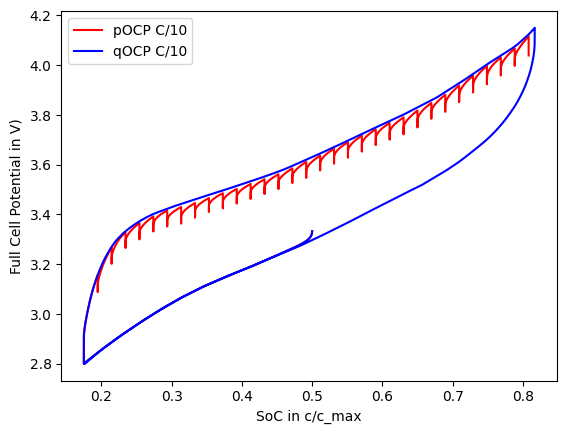

In [151]:
#Paper replication PLOTS

# #Voltage components

# sim = pybamm.Simulation(
#     model,
#     parameter_values=param,
#     experiment = gitt_c10,
#     solver=pybamm.IDAKLUSolver(rtol=1e-3, atol=1e-3)
# )
# solution = sim.solve()

# pybamm.plot_voltage_components(solution)



#pulsed OCP c/10

sim = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment = gitt_c1,
    solver=pybamm.IDAKLUSolver(rtol=1e-3, atol=1e-3)
)
solution = sim.solve()

#pybamm.plot_voltage_components(solution)

pOCP_c10 = solution["Voltage [V]"].data
pSoC_c10 = 0.5 - (solution["Discharge capacity [A.h]"].data/solution["Total lithium capacity [A.h]"].data)
#0.5 minus because the initial condition is @0.5C
time = solution["Time [s]"].data


plt.figure()
plt.plot(pSoC_c10, pOCP_c10, label = "pOCP C/10",color="red")



#quasi OCP c/10


sim = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment = cc_c1,
    solver=pybamm.IDAKLUSolver(rtol=1e-3, atol=1e-3)
)
solution = sim.solve()


qOCP_c10 = solution["Voltage [V]"].data
qSoC_c10 = 0.5 - (solution["Discharge capacity [A.h]"].data/solution["Total lithium capacity [A.h]"].data)



plt.plot(qSoC_c10, qOCP_c10, label = "qOCP C/10",color="blue")

plt.xlabel("SoC in c/c_max")
plt.ylabel("Full Cell Potential in V)")
plt.legend(loc = 'best')



2025-08-31 13:01:37.131 - [INFO] callbacks.on_experiment_start(162): Start running experiment
2025-08-31 13:01:37.132 - [INFO] parameter_values.process_model(475): Start setting parameters for Doyle-Fuller-Newman model
2025-08-31 13:01:37.133 - [VERBOSE] logger.func(7): Processing parameters for Variable(0x1d5b6e2c738b27a4, Discharge capacity [A.h], children=[], domains={}) (rhs)
2025-08-31 13:01:37.135 - [VERBOSE] logger.func(7): Processing parameters for Variable(0x50a4f9aea761037c, Throughput capacity [A.h], children=[], domains={}) (rhs)
2025-08-31 13:01:37.136 - [VERBOSE] logger.func(7): Processing parameters for Variable(0x6c0144a3cca6db64, Negative electrode hysteresis state, children=[], domains={'primary': ['negative electrode'], 'secondary': ['current collector']}) (rhs)
2025-08-31 13:01:37.141 - [VERBOSE] logger.func(7): Processing parameters for Variable(0x11c37218d371aa68, Negative particle concentration [mol.m-3], children=[], domains={'primary': ['negative particle'], 's

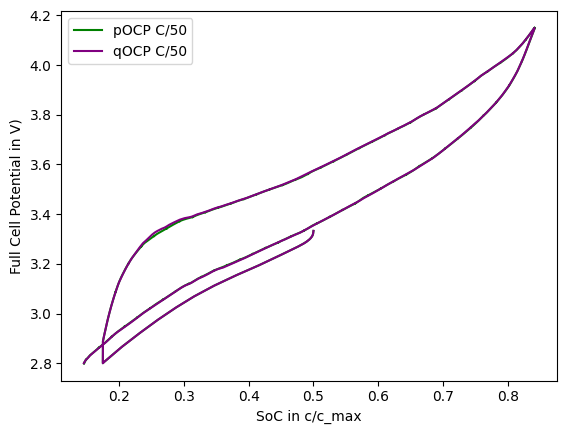

In [152]:
#pulsed OCP c/50


sim = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment = gitt_c50,
    solver=pybamm.IDAKLUSolver(rtol=1e-3, atol=1e-3)
)
solution = sim.solve()


pOCP_c50 = solution["Voltage [V]"].data
pSoC_c50 = 0.5 - (solution["Discharge capacity [A.h]"].data/solution["Total lithium capacity [A.h]"].data)


plt.figure()
plt.plot(pSoC_c50, pOCP_c50, label = "pOCP C/50", color = "green")



#quasi OCP c/50


sim = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment = cc_c50,
    solver=pybamm.IDAKLUSolver(rtol=1e-3, atol=1e-3)
)
solution = sim.solve()


qOCP_c50 = solution["Voltage [V]"].data
qSoC_c50 = 0.5 - (solution["Discharge capacity [A.h]"].data/solution["Total lithium capacity [A.h]"].data)
#0.5 minus because the initial condition is @0.5C
time = solution["Time [s]"].data

plt.plot(qSoC_c50, qOCP_c50, label = "qOCP C/50", color = "purple")


#plot settings

plt.xlabel("SoC in c/c_max")
plt.ylabel("Full Cell Potential in V)")
plt.legend(loc = 'best')

In [153]:


#debug stuff where i plotted all concentrations

# sim.plot(output_variables=[
#     "Negative particle concentration [mol.m-3]",
#     "X-averaged negative particle concentration [mol.m-3]",
#     "R-averaged negative particle concentration [mol.m-3]",
#     "Average negative particle concentration [mol.m-3]",
#     "Negative particle surface concentration [mol.m-3]",
#     "X-averaged negative particle surface concentration [mol.m-3]",
#     "Minimum negative particle concentration [mol.m-3]",
#     "Maximum negative particle concentration [mol.m-3]",
#     "Minimum negative particle Minimum negative particle surface concentration [mol.m-3]",
#     "Maximum negative particle surface concentration [mol.m-3]",
#     "Negative particle concentration",
#     "X-averaged negative particle concentration",
#     "R-averaged negative particle concentration",
#     "Average negative particle concentration",
#     "Negative particle surface concentration",
#     "X-averaged negative particle surface concentration",
#     "Minimum negative particle concentration",
#     "Maximum negative particle concentration",
#     "Minimum negative particle surface concentration",
#     "Maximum negative particle surface concentration"
# ])

# sim.plot(output_variables=[
#     "Positive particle concentration [mol.m-3]",
#     "X-averaged positive particle concentration [mol.m-3]",
#     "R-averaged positive particle concentration [mol.m-3]",
#     "Average positive particle concentration [mol.m-3]",
#     "Positive particle surface concentration [mol.m-3]",
#     "X-averaged positive particle surface concentration [mol.m-3]",
#     "Minimum positive particle concentration [mol.m-3]",
#     "Maximum positive particle concentration [mol.m-3]",
#     "Minimum positive particle Minimum positive particle surface concentration [mol.m-3]",
#     "Maximum positive particle surface concentration [mol.m-3]",
#     "Positive particle concentration",
#     "X-averaged positive particle concentration",
#     "R-averaged positive particle concentration",
#     "Average positive particle concentration",
#     "Positive particle surface concentration",
#     "X-averaged positive particle surface concentration",
#     "Minimum positive particle concentration",
#     "Maximum positive particle concentration",
#     "Minimum positive particle surface concentration",
#     "Maximum positive particle surface concentration"
# ])


# sim.plot(output_variables=[
#     "Electrolyte concentration concatenation [mol.m-3]",
#     "Negative electrolyte concentration [mol.m-3]",
#     "X-averaged negative electrolyte concentration [mol.m-3]",
#     "Separator electrolyte concentration [mol.m-3]",
#     "X-averaged separator electrolyte concentration [mol.m-3]",
#     "Positive electrolyte concentration [mol.m-3]",
#     "X-averaged positive electrolyte concentration [mol.m-3]",
#     "Electrolyte concentration [mol.m-3]",
#     "X-averaged electrolyte concentration [mol.m-3]"
# ])


# sim.plot(output_variables=[
#     "Porosity times concentration [mol.m-3]",
#     "Negative electrode porosity times concentration [mol.m-3]",
#     "Separator porosity times concentration [mol.m-3]",
#     "Positive electrode porosity times concentration [mol.m-3]",
#     "Negative electrode volume-averaged concentration",
#     "Negative electrode volume-averaged concentration [mol.m-3]",
#     "Positive electrode volume-averaged concentration",
#     "Positive electrode volume-averaged concentration [mol.m-3]"
# ])


# sim.plot(output_variables=[
#     "X-averaged concentration overpotential [V]",
#     "Negative particle concentration overpotential [V]",
#     "Positive particle concentration overpotential [V]",
#     "Particle concentration overpotential [V]",
#     "Battery particle concentration overpotential [V]",
#     "Battery negative particle concentration overpotential [V]",
#     "Battery positive particle concentration overpotential [V]",
#     "X-averaged battery concentration overpotential [V]"
# ])


In [154]:
#more debug stuff where I plotted everything

# sim.plot(output_variables=[
#     "Time [s]", "Time [min]", "Time [h]",
#     "x [m]", "x_n [m]", "x_s [m]", "x_p [m]",
#     "r_n [m]", "r_p [m]"
# ])


# sim.plot(output_variables=[
#     "Current variable [A]", "Total current density [A.m-2]", "Current [A]", "C-rate",
#     "Voltage [V]", "Terminal voltage [V]", "Voltage expression [V]", "Local voltage [V]",
#     "Positive current collector potential [V]", "Negative current collector potential [V]",
#     "Contact overpotential [V]"
# ])


# sim.plot(output_variables=[
#     "Discharge capacity [A.h]", "Throughput capacity [A.h]",
#     "Discharge energy [W.h]", "Throughput energy [W.h]",
#     "Negative electrode capacity [A.h]", "Positive electrode capacity [A.h]"
# ])


# sim.plot(output_variables=[
#     "Porosity", "Porosity change",
#     "Negative electrode porosity", "X-averaged negative electrode porosity", "Negative electrode porosity change [s-1]", "X-averaged negative electrode porosity change [s-1]",
#     "Separator porosity", "X-averaged separator porosity", "Separator porosity change [s-1]", "X-averaged separator porosity change [s-1]",
#     "Positive electrode porosity", "X-averaged positive electrode porosity", "Positive electrode porosity change [s-1]", "X-averaged positive electrode porosity change [s-1]",
#     "Negative electrode active material volume fraction", "X-averaged negative electrode active material volume fraction", "Negative electrode active material volume fraction change [s-1]", "X-averaged negative electrode active material volume fraction change [s-1]",
#     "Positive electrode active material volume fraction", "X-averaged positive electrode active material volume fraction", "Positive electrode active material volume fraction change [s-1]", "X-averaged positive electrode active material volume fraction change [s-1]"
# ])


# sim.plot(output_variables=[
#     "Negative electrode interface utilisation", "Negative electrode interface utilisation variable",
#     "X-averaged negative electrode interface utilisation", "X-averaged negative electrode interface utilisation variable",
#     "Positive electrode interface utilisation", "Positive electrode interface utilisation variable",
#     "X-averaged positive electrode interface utilisation", "X-averaged positive electrode interface utilisation variable"
# ])


# sim.plot(output_variables=[
#     "Negative particle radius", "Negative particle radius [m]", "X-averaged negative particle radius [m]",
#     "Negative electrode surface area to volume ratio [m-1]", "X-averaged negative electrode surface area to volume ratio [m-1]",
#     "Positive particle radius", "Positive particle radius [m]", "X-averaged positive particle radius [m]",
#     "Positive electrode surface area to volume ratio [m-1]", "X-averaged positive electrode surface area to volume ratio [m-1]"
# ])


# sim.plot(output_variables=[
#     "Negative particle concentration [mol.m-3]", "X-averaged negative particle concentration [mol.m-3]",
#     "R-averaged negative particle concentration [mol.m-3]", "Average negative particle concentration [mol.m-3]",
#     "Negative particle surface concentration [mol.m-3]", "X-averaged negative particle surface concentration [mol.m-3]",
#     "Minimum negative particle concentration [mol.m-3]", "Maximum negative particle concentration [mol.m-3]",
#     "Positive particle concentration [mol.m-3]", "X-averaged positive particle concentration [mol.m-3]",
#     "R-averaged positive particle concentration [mol.m-3]", "Average positive particle concentration [mol.m-3]",
#     "Positive particle surface concentration [mol.m-3]", "X-averaged positive particle surface concentration [mol.m-3]",
#     "Porosity times concentration [mol.m-3]",
#     "Negative electrode porosity times concentration [mol.m-3]",
#     "Separator porosity times concentration [mol.m-3]",
#     "Positive electrode porosity times concentration [mol.m-3]",
#     "Total lithium in electrolyte [mol]"
# ])


# sim.plot(output_variables=[
#     "Negative particle stoichiometry", "X-averaged negative particle stoichiometry",
#     "Positive particle stoichiometry", "X-averaged positive particle stoichiometry",
#     "Negative electrode extent of lithiation", "X-averaged negative electrode extent of lithiation",
#     "Positive electrode extent of lithiation", "X-averaged positive electrode extent of lithiation"
# ])


# sim.plot(output_variables=[
#     "Negative electrode potential [V]", "X-averaged negative electrode potential [V]",
#     "Negative electrode ohmic losses [V]", "X-averaged negative electrode ohmic losses [V]",
#     "Positive electrode potential [V]", "X-averaged positive electrode potential [V]",
#     "Positive electrode ohmic losses [V]", "X-averaged positive electrode ohmic losses [V]"
# ])


# sim.plot(output_variables=[
#     "Electrolyte potential [V]", "X-averaged electrolyte potential [V]",
#     "Negative electrolyte potential [V]", "X-averaged negative electrolyte potential [V]",
#     "Positive electrolyte potential [V]", "X-averaged positive electrolyte potential [V]",
#     "Separator electrolyte potential [V]", "X-averaged separator electrolyte potential [V]",
#     "Gradient of electrolyte potential [V.m-1]"
# ])


